In [220]:
# Import required libraries
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from datetime import datetime
import matplotlib.pyplot as plt
import yfinance as yf
from statsmodels.tsa.stattools import adfuller, kpss


In [221]:
# Set the start and end date for data
start_date = datetime(2023, 1, 1)
end_date = datetime(2024, 1, 31)
stock_symbol = 'NVDA'

# Download stock data
stock = yf.download(stock_symbol, start_date, end_date)

[*********************100%***********************]  1 of 1 completed


              Open    High     Low   Close  Adj Close     Volume  Log Price  \
Date                                                                          
2023-01-03  14.851  14.996  14.096  14.315  14.305582  401277000   2.660650   
2023-01-04  14.567  14.853  14.241  14.749  14.739295  431324000   2.690517   
2023-01-05  14.491  14.564  14.148  14.265  14.255614  389168000   2.657151   
2023-01-06  14.474  15.010  14.034  14.859  14.849225  405044000   2.697948   
2023-01-09  15.284  16.056  15.141  15.628  15.617718  504231000   2.748406   

            Log Returns  
Date                     
2023-01-03          NaN  
2023-01-04     0.029867  
2023-01-05    -0.033366  
2023-01-06     0.040797  
2023-01-09     0.050458  


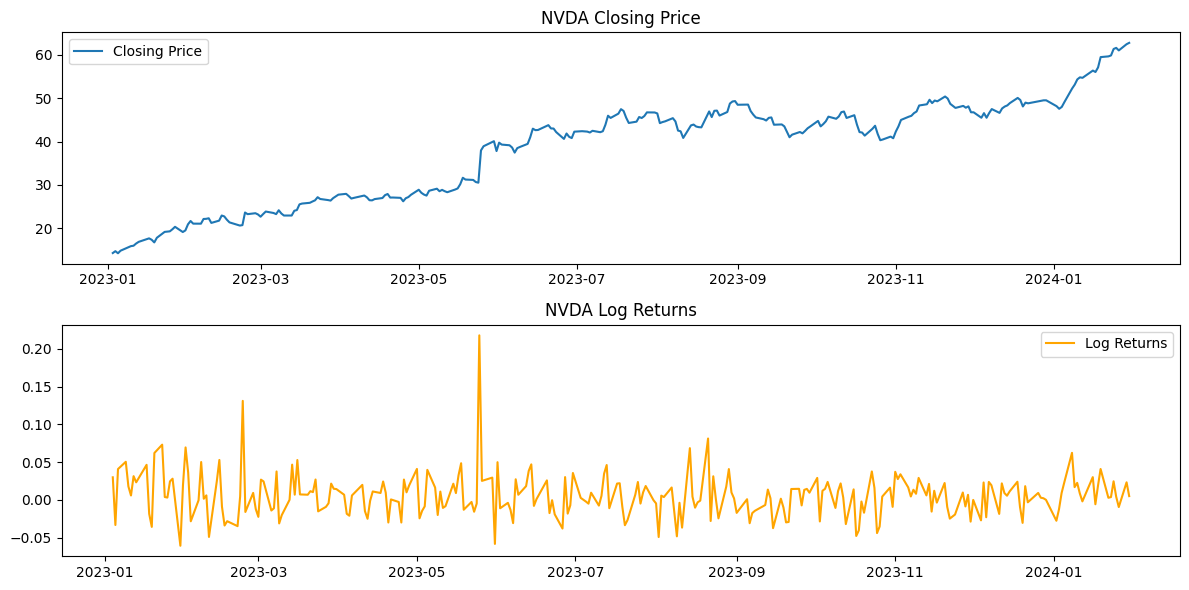

In [222]:
# Apply log transformation to the adjusted close price
stock['Log Price'] = np.log(stock['Adj Close'])

# Calculate log returns as the difference of log prices
stock['Log Returns'] = stock['Log Price'].diff()

# Check if 'Log Returns' is created successfully
print(stock.head())  # Display the first few rows to verify

# Extract the log returns as a numpy array and calculate the length
Y = stock['Log Returns'].dropna().values  # Drop any NaN values before use
S = len(Y)  # Length of time series after dropping NaN values

# Plot the closing prices and log returns for visual inspection
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(stock['Adj Close'], label='Closing Price')
plt.title(f'{stock_symbol} Closing Price')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(stock['Log Returns'], label='Log Returns', color='orange')
plt.title(f'{stock_symbol} Log Returns')
plt.legend()
plt.tight_layout()
plt.show()


In [223]:
# Perform ADF (Augmented Dickey-Fuller) Test to check for stationarity
adf_result = adfuller(Y)
print("ADF Test Statistic:", adf_result[0])
print("p-value:", adf_result[1])
for key, value in adf_result[4].items():
    print(f"Critical Value {key}: {value}")
if adf_result[1] < 0.05:
    print("The series is stationary based on the ADF test (p < 0.05).")
else:
    print("The series is non-stationary based on the ADF test (p >= 0.05).")


ADF Test Statistic: -10.650559267741908
p-value: 4.673128508371095e-19
Critical Value 1%: -3.455175292841607
Critical Value 5%: -2.8724677563219485
Critical Value 10%: -2.57259315846006
The series is stationary based on the ADF test (p < 0.05).


In [224]:
# Perform KPSS (Kwiatkowski-Phillips-Schmidt-Shin) Test to check for stationarity
kpss_result = kpss(Y, regression='c')
print("KPSS Test Statistic:", kpss_result[0])
print("p-value:", kpss_result[1])
for key, value in kpss_result[3].items():
    print(f"Critical Value {key}: {value}")
if kpss_result[1] > 0.05:
    print("The series is stationary based on the KPSS test (p > 0.05).")
else:
    print("The series is non-stationary based on the KPSS test (p <= 0.05).")


KPSS Test Statistic: 0.3091320956170109
p-value: 0.1
Critical Value 10%: 0.347
Critical Value 5%: 0.463
Critical Value 2.5%: 0.574
Critical Value 1%: 0.739
The series is stationary based on the KPSS test (p > 0.05).


C:\Users\56111\AppData\Local\Temp\ipykernel_484188\2711327357.py:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(Y, regression='c')


In [225]:
def garch(garch_params, *args):
    mu = garch_params[0]
    omega = garch_params[1]
    alpha = garch_params[2]
    beta = garch_params[3]
    mu1 = garch_params[4]
    sig1 = garch_params[5]
    mu2 = garch_params[6]
    sig2 = garch_params[7]
    p = garch_params[8]
    sigma2, F1, F2, v = {}, {}, {}, {}
    GARCH_dens1, GARCH_dens2, GARCH_dens_mix = {}, {}, {}
    sigma2[0] = np.var(Y)
    Likelihood = 0
    for t in range(1, S):
        sigma2[t] = omega + alpha * ((Y[t-1] - mu) ** 2) + beta * sigma2[t-1]
        if sigma2[t] < 0:
            sigma2[t] = 1e-2
        mixture_shocks1 = np.random.normal(mu1, sig1, 1)
        mixture_shocks2 = np.random.normal(mu2, sig2, 1)
        F1[t] = Y[t] - mu - np.sqrt(sigma2[t]) * mixture_shocks1
        F2[t] = Y[t] - mu - np.sqrt(sigma2[t]) * mixture_shocks2
        v[t] = sigma2[t]
        GARCH_dens1[t] = (1/2) * np.log(2 * np.pi) + (1/2) * np.log(v[t]) + (1/2) * (F1[t] / v[t])
        GARCH_dens2[t] = (1/2) * np.log(2 * np.pi) + (1/2) * np.log(v[t]) + (1/2) * (F2[t] / v[t])
        u = np.random.uniform(0, 1, 1)
        GARCH_dens_mix[t] = (u <= p) * GARCH_dens1[t] + (u > p) * GARCH_dens2[t]
        Likelihood += GARCH_dens_mix[t]

    return Likelihood


In [226]:
def garch_path(garch_params, *args):
    mu = garch_params[0]
    omega = garch_params[1]
    alpha = garch_params[2]
    beta = garch_params[3]
    mu1 = garch_params[4]
    sig1 = garch_params[5]
    mu2 = garch_params[6]
    sig2 = garch_params[7]
    p = garch_params[8]
    sigma2, path = {}, {}
    sigma2[0] = np.var(Y)
    path[0] = np.array([Y[0]])
    for t in range(1, S):
        sigma2[t] = omega + alpha * ((Y[t-1] - mu) ** 2) + beta * sigma2[t-1]
        if sigma2[t] < 0:
            sigma2[t] = 1e-2
        mixture_shocks1 = np.random.normal(mu1, sig1, 1)
        mixture_shocks2 = np.random.normal(mu2, sig2, 1)
        u = np.random.uniform(0, 1, 1)
        mixture_shocks = (u <= p) * mixture_shocks1 + (u > p) * mixture_shocks2
        path[t] = mu + np.sqrt(sigma2[t]) * mixture_shocks

    return path, sigma2


In [227]:
# Initial parameter guess
garch_param0 = np.array([np.mean(Y), np.var(Y) / 1600, 0.06, 0.78, 0.04, 0.82, 0.002, 0.92, 0.02])

# Optimize parameters using maximum likelihood estimation
garch_results = minimize(garch, garch_param0, method='BFGS', tol=1e-2, options={'disp': True})
garch_param_star = garch_results.x  # Optimized parameters


         Current function value: -3398.805382
         Iterations: 1
         Function evaluations: 201
         Gradient evaluations: 19


c:\Users\56111\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\optimize\_minimize.py:726: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


RMSE value is: 3.0132055900423778%


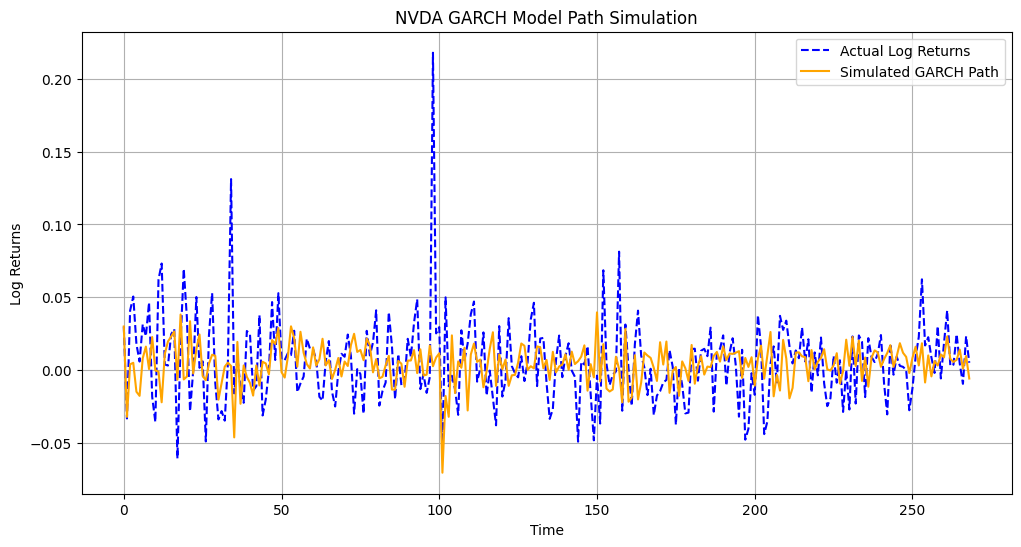

In [228]:
# Simulate the GARCH path using the optimized parameters
simulated_garch_path, garch_variance_path = garch_path(garch_param_star)

# Extract the simulated GARCH path for plotting and RMSE calculation
Y_GARCH = [simulated_garch_path[t][0] for t in range(S)]
GARCH_prediction = list(Y_GARCH)

# Calculate RMSE
RMSE = np.sqrt(np.mean((np.array(GARCH_prediction) - np.array(Y))**2))
print(f'RMSE value is: {RMSE*100}%')

# Visualization of GARCH path
plt.figure(figsize=(12, 6))
plt.plot(Y, label='Actual Log Returns', color='blue', linestyle='--')
plt.plot(list(simulated_garch_path.values()), label='Simulated GARCH Path', color='orange')
plt.title(f'{stock_symbol} GARCH Model Path Simulation')
plt.xlabel('Time')
plt.ylabel('Log Returns')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()


In [229]:
def kalman_filter(param,*args):
    # initialize params
    Z = param[0]
    T = param[1]
    H = param[2]
    Q = param[3]
    # initialize vector values:
    u_predict,  u_update,  P_predict, P_update, v, F = {},{},{},{},{},{}
    u_update[0] = Y[0]
    u_predict[0] = u_update[0] 
    P_update[0] = np.var(Y)/4 
    P_predict[0] =  T*P_update[0]*np.transpose(T)+Q  
    Likelihood = 0
    for s in range(1, S):
        F[s] = Z*P_predict[s-1]*np.transpose(Z)+H 
        v[s]= Y[s-1]-Z*u_predict[s-1]   
        u_update[s] = u_predict[s-1]+P_predict[s-1]*np.transpose(Z)*(1/F[s])*v[s]
        u_predict[s] = T*u_update[s]
        P_update[s] = P_predict[s-1]-P_predict[s-1]*np.transpose(Z)*(1/F[s])*Z*P_predict[s-1]
        P_predict[s] = T*P_update[s]*np.transpose(T)+Q
        Likelihood += (1/2)*np.log(2*np.pi)+(1/2)*np.log(abs(F[s]))+(1/2)*np.transpose(v[s])*(1/F[s])*v[s]      
    
    return Likelihood

In [230]:
def kalman_smoother(params, *args):
    # initialize params
    Z = params[0]
    T = params[1]
    H = params[2]
    Q = params[3] 
    # initialize vector values:
    u_predict,  u_update,  P_predict, P_update, v, F = {},{},{},{},{},{}
    u_update[0] = Y[0]
    u_predict[0] = u_update[0] 
    P_update[0] = np.var(Y)/4 
    P_predict[0] =  T*P_update[0]*np.transpose(T)+Q  
    for s in range(1, S):
        F[s] = Z*P_predict[s-1]*np.transpose(Z)+H 
        v[s]=Y[s-1]-Z*u_predict[s-1]   
        u_update[s] = u_predict[s-1]+P_predict[s-1]*np.transpose(Z)*(1/F[s])*v[s]
        u_predict[s] = T*u_update[s]
        P_update[s] = P_predict[s-1]-P_predict[s-1]*np.transpose(Z)*(1/F[s])*Z*P_predict[s-1]
        P_predict[s] = T*P_update[s]*np.transpose(T)+Q
    
    u_smooth, P_smooth = {}, {}
    u_smooth[S-1] = u_update[S-1]
    P_smooth[S-1] = P_update[S-1]    
    for t in range(S-1, 0, -1):
        u_smooth[t-1] = u_update[t] + P_update[t]*np.transpose(T)/P_predict[t]*(u_smooth[t]-T*u_update[s])
        P_smooth[t-1] = P_update[t] + P_update[t]*np.transpose(T)/P_predict[t]*(P_smooth[t]-P_predict[t])/P_predict[t]*T*P_update[t]
    
    # del u_update[-1]
    smooth_path = u_smooth
    return smooth_path 

In [231]:
# Minimize Kalman filter likelihood function
kalman_param0 = np.array([1.05, 0.96, np.var(Y) / 200, np.var(Y) / 100])
kalman_results = minimize(kalman_filter, kalman_param0, method='BFGS', tol=1e-4, options={'disp': True})


         Current function value: -180.817707
         Iterations: 3
         Function evaluations: 332
         Gradient evaluations: 65


c:\Users\56111\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\optimize\_minimize.py:726: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


In [232]:
# Smooth and visualize the estimated path
param_star = kalman_results.x
path = kalman_smoother(param_star, Y, S)
sorted_path = dict(sorted(path.items()))
Y_kalmanFilter = sorted_path.values()

RMSE values is: $ 0.03988860591187208


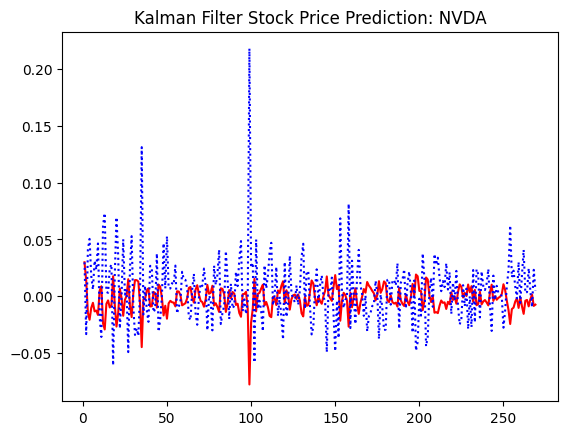

In [233]:
# Time vector for plotting
timevec = np.linspace(1,S,S)
plt.title('Kalman Filter Stock Price Prediction: '+ stock_symbol)
plt.plot(timevec, Y_kalmanFilter,'r',timevec, Y,'b:')

# Extracting the dictionary values into a list (in the same order as keys)
kalman_values = list(Y_kalmanFilter)

# Calculate RMSE
RMSE = np.sqrt(np.mean((np.array(kalman_values) - np.array(Y))**2))
print('RMSE values is: $', RMSE)

In [234]:
spread = np.sqrt(np.var([garch_param_star[1] + garch_param_star[2] * (y - garch_param_star[0]) ** 2 + garch_param_star[3] * garch_param_star[1] for y in Y]))
midprice_kalman = np.array(list(kalman_smoother(kalman_param_star, Y, S).values()))
upper_bound = midprice_kalman + spread
lower_bound = midprice_kalman - spread


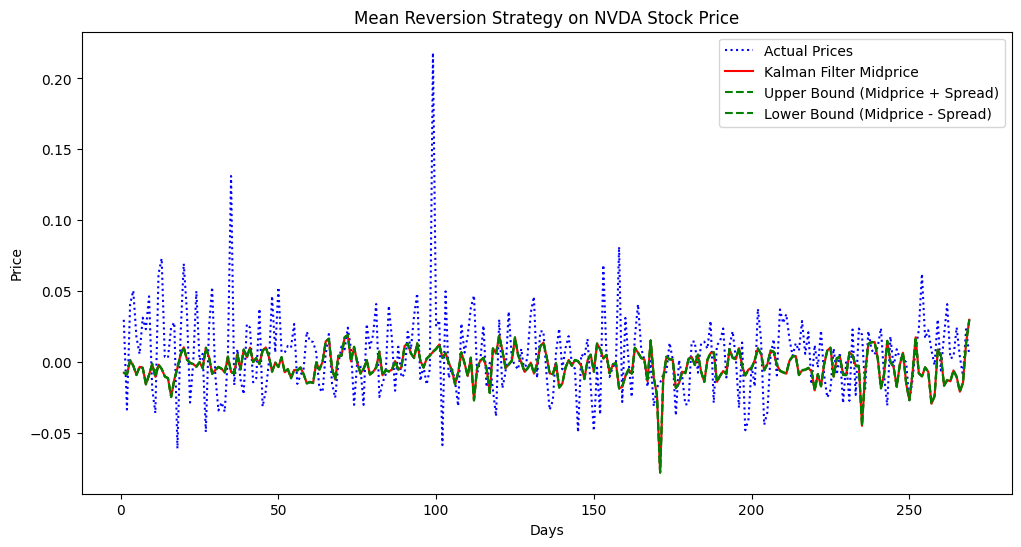

In [235]:
timevec = np.linspace(1, S, S)
plt.figure(figsize=(12, 6))
plt.plot(timevec, Y, 'b:', label='Actual Prices')
plt.plot(timevec, midprice_kalman, 'r', label='Kalman Filter Midprice')
plt.plot(timevec, upper_bound, 'g--', label='Upper Bound (Midprice + Spread)')
plt.plot(timevec, lower_bound, 'g--', label='Lower Bound (Midprice - Spread)')
plt.fill_between(timevec, lower_bound, upper_bound, color='gray', alpha=0.3)
plt.xlabel('Days')
plt.ylabel('Price')
plt.title('Mean Reversion Strategy on NVDA Stock Price')
plt.legend()
plt.show()